In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import SparseRandomProjection 
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import scipy.sparse as sps
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.linalg import pinv
from sklearn.model_selection import GridSearchCV, learning_curve, ShuffleSplit, train_test_split
import itertools
import matplotlib.pyplot as plt
from time import clock
seed = 5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def kMeans(data, k = range(1, 10), max_iter = 1000):
    SSE = {}
    time = {}
    for iterK in k:
        st = clock()
        kmeans = KMeans(n_clusters = iterK, max_iter = max_iter, random_state= seed).fit(data)
        time[iterK] = clock() - st
        SSE[iterK] = kmeans.inertia_

        if iterK > 1:
            sil_coeff = silhouette_score(data, kmeans.labels_, metric='euclidean')
            print ("For n_clusters={}, The Silhouette Coefficient is {}".format(iterK, sil_coeff))
    
    plt.subplot(2, 1, 1)
    plt.plot(list(SSE.keys()), list(SSE.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    
    plt.subplot(2, 1, 2)
    plt.plot(list(time.keys()), list(time.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Running TIme")
    
    return plt

In [3]:
def loadCSVData(fileName, targetCol, scaler = preprocessing.MinMaxScaler()):
    data = pd.read_csv(fileName)
    x = data.loc[:, data.columns != targetCol]
    y = data[targetCol]

    xCol = x.columns
    
    x = pd.DataFrame(scaler.fit_transform(x), columns=xCol)
    return x, y

For n_clusters=2, The Silhouette Coefficient is 0.24619145662552291
For n_clusters=3, The Silhouette Coefficient is 0.1920098321984321
For n_clusters=4, The Silhouette Coefficient is 0.17089588913911696
For n_clusters=5, The Silhouette Coefficient is 0.16857005209355336
For n_clusters=6, The Silhouette Coefficient is 0.14416732636858587
For n_clusters=7, The Silhouette Coefficient is 0.14336640180799867
For n_clusters=8, The Silhouette Coefficient is 0.13931575000297736
For n_clusters=9, The Silhouette Coefficient is 0.13251723081081596
For n_clusters=10, The Silhouette Coefficient is 0.13752204223412343


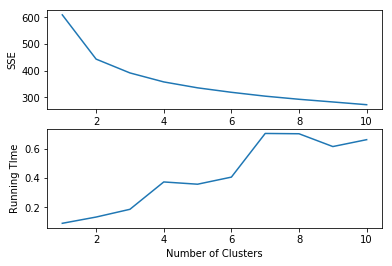

In [4]:
#Wine Data - KMeans
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("winequality-white.csv", "GoodQuality")
plt = kMeans(x, k = range(1, 11), max_iter = 1000)
plt.show()

For n_clusters=2, The Silhouette Coefficient is 0.4265455294723743
For n_clusters=3, The Silhouette Coefficient is 0.37226918888087324
For n_clusters=4, The Silhouette Coefficient is 0.3291521934350927
For n_clusters=5, The Silhouette Coefficient is 0.29751689597213826
For n_clusters=6, The Silhouette Coefficient is 0.3174548458548584
For n_clusters=7, The Silhouette Coefficient is 0.30420458708044623
For n_clusters=8, The Silhouette Coefficient is 0.31172791116891546
For n_clusters=9, The Silhouette Coefficient is 0.27977855001807256
For n_clusters=10, The Silhouette Coefficient is 0.2725295168439207


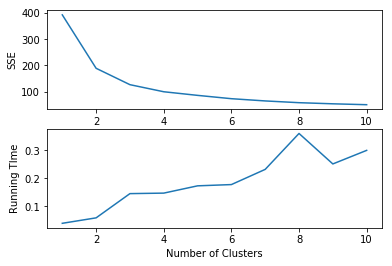

In [5]:
#Abalone Data - KMeans
scaler = preprocessing.MinMaxScaler ()
x, y = loadCSVData("abalone.csv", "sex")
plt = kMeans(x, k = range(1, 11), max_iter = 1000)
plt.show()

In [6]:
def gMM(data, k = range(1, 10), max_iter = 1000):
    BIC = {}
    time = {}
    for iterK in k:
        st = clock()
        gmm = GaussianMixture(n_components= iterK, random_state= seed, n_init = 5, max_iter = max_iter)
        gmm.fit(data)

        time[iterK] = clock()-  st
        BIC[iterK] = gmm.bic(data)
        
    plt.subplot(2, 1, 1)
    plt.plot(list(BIC.keys()), list(BIC.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("BIC")

    plt.subplot(2, 1, 2)
    plt.plot(list(time.keys()), list(time.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Running TIme")
    
    return plt

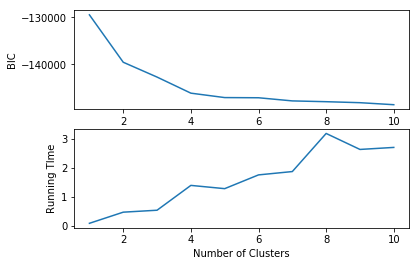

In [7]:
#Wine Data - EM (Gaussian Mixture Model)
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("winequality-white.csv", "GoodQuality")
plt = gMM(x, k = range(1, 11), max_iter = 1000)

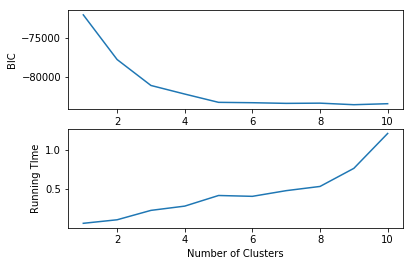

In [8]:
#Abalone - EM (Gaussian Mixture Model)
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("abalone.csv", "sex")
plt = gMM(x, k = range(1, 11), max_iter = 1000)

In [9]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

def principalComponentAnalysis(data, n_components):
    pc = PCA(n_components = n_components, random_state= seed).fit_transform(data)
    
    varianceExplained = {}
    
    explained_variance = np.var(pc, axis=0)
    explained_variance_ratio = explained_variance / np.sum(explained_variance)
    pcaCumSum = np.cumsum(explained_variance_ratio)
    
    for iterComp in range(n_components):
        varianceExplained[iterComp] = pcaCumSum[iterComp]
    
    plt.figure()
    plt.plot(list(varianceExplained.keys()), list(varianceExplained.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Variance Explained")    

    return plt, varianceExplained, pc

def independentComponentAnalysis(data, n_components):
    kurtosis = {}

    for iterN in range(1, n_components):
        ic = FastICA(n_components = iterN, random_state= seed).fit_transform(data)
        ic = pd.DataFrame(ic)
        ic = ic.kurtosis(axis = 0)
        kurtosis[iterN] = ic.abs().mean()
    
    plt.figure()
    plt.plot(list(kurtosis.keys()), list(kurtosis.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Kurtosis")     
    
    return plt, kurtosis, ic


def randomProjections(data, n_components):
    pWDC = {}
    rError = {}
    
    for iterN in range(1, n_components):
        rp = SparseRandomProjection(n_components = iterN, random_state= seed)
        
        rpCopy = rp
        pWDC[iterN] = pairwiseDistCorr(rp.fit_transform(data), data)
        
        rpCopy.fit(data)
        rError[iterN] = reconstructionError(rpCopy, data)
    
    
    plt.subplot(2, 1, 1)
    plt.plot(list(pWDC.keys()), list(pWDC.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Pair-wise Distance Correlation")     
    
    plt.subplot(2, 1, 2)
    plt.plot(list(rError.keys()), list(rError.values()))
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error")     

    return plt, pairwiseDistCorr, reconstructionError, rp

def randomForest(x, y, n_estimators, class_weight):
    rfc = RandomForestClassifier(n_estimators= n_estimators, class_weight="balanced", random_state= seed)
    features = rfc.fit(x, y).feature_importances_ 
    
    fi = {}
    
    for iterF in range(len(x.columns)):
        fi[x.columns[iterF]] = features[iterF]
    
    return fi

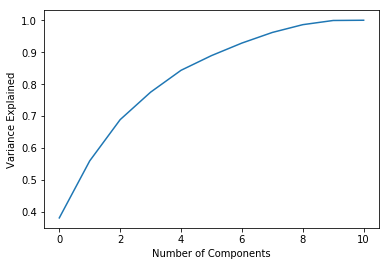

In [10]:
#Wine Data - PCA
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("winequality-white.csv", "GoodQuality")
n_components = len(x.columns)

plt, varianceExplained, pca = principalComponentAnalysis(x, n_components)
plt.show()

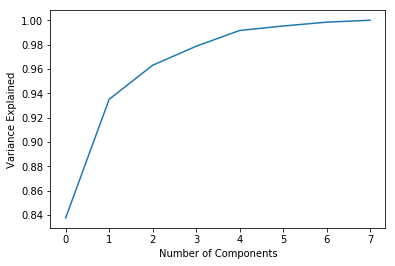

In [11]:
#Abalone - PCA
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("abalone.csv", "sex")
n_components = len(x.columns)

plt, varianceExplained, pca = principalComponentAnalysis(x, n_components)
plt.show()

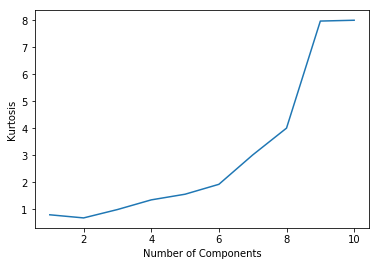

In [12]:
#Wine Data - ICA
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("winequality-white.csv", "GoodQuality")
n_components = len(x.columns)

plt, kurtosis, ica = independentComponentAnalysis(x, n_components)
plt.show()

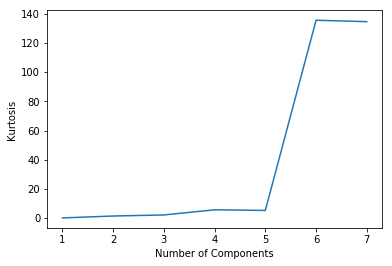

In [13]:
#Abalone - ICA
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("abalone.csv", "sex")
n_components = len(x.columns)

plt, kurtosis, ica = independentComponentAnalysis(x, n_components)
plt.show()

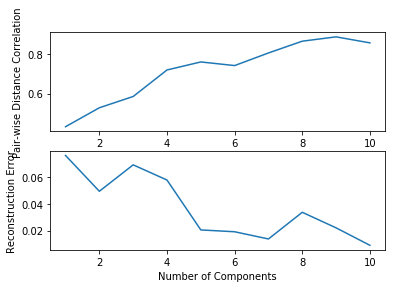

In [14]:
#Wine Data - RP
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("winequality-white.csv", "GoodQuality")
n_components = len(x.columns)

plt, pairwiseDistCorr, reconstructionError, rp = randomProjections(x, n_components)
plt.show()

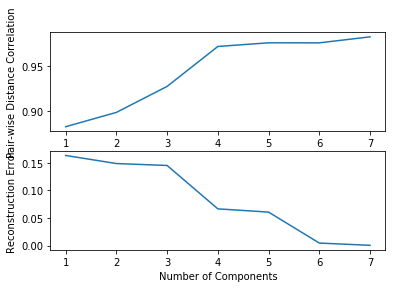

In [15]:
#Abalone - RP
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("abalone.csv", "sex")
n_components = len(x.columns)

plt, pairwiseDistCorr, reconstructionError, rp = randomProjections(x, n_components)
plt.show()

In [16]:
#Wine Data - RF
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("winequality-white.csv", "GoodQuality")
n_estimators = 100

features = randomForest(x, y, n_estimators, "balanced")
print (features)

{'fixed acidity': 0.06356593960403034, 'volatile acidity': 0.11448612543544759, 'citric acid': 0.07526055845569675, 'residual sugar': 0.08028318839284551, 'chlorides': 0.08388097338342072, 'free sulfur dioxide': 0.09593251743121761, 'total sulfur dioxide': 0.08326159505143906, 'density': 0.11696780382358464, 'pH': 0.07312666325818046, 'sulphates': 0.06351761670418571, 'alcohol': 0.14971701845995164}


In [17]:
#Abalone - RF
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("abalone.csv", "sex")
n_estimators = 100

features = randomForest(x, y, n_estimators, "balanced")
print (features)

{'length': 0.111318267918942, 'diameter': 0.1059924025188252, 'height': 0.09561669523440061, 'wholeweight': 0.1508892103146603, 'shuckedweight': 0.16228914271403297, 'visceraweight': 0.15435256762104937, 'shellweight': 0.1419690685596682, 'rings': 0.07757264511842134}


For n_clusters=2, The Silhouette Coefficient is 0.27668586812253854
For n_clusters=3, The Silhouette Coefficient is 0.22391719426467727
For n_clusters=4, The Silhouette Coefficient is 0.20190533877456576
For n_clusters=5, The Silhouette Coefficient is 0.20268895036440723
For n_clusters=6, The Silhouette Coefficient is 0.1664861802268108
For n_clusters=7, The Silhouette Coefficient is 0.16967293784444054
For n_clusters=8, The Silhouette Coefficient is 0.17004820082674463
For n_clusters=9, The Silhouette Coefficient is 0.16000157307185728
For n_clusters=10, The Silhouette Coefficient is 0.15841869360685093


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

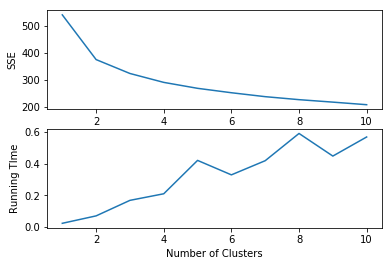

In [18]:
#Wine Data - PCA Dimensionality Reduced KMeans
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("winequality-white.csv", "GoodQuality")

pc = PCA(n_components = 6, random_state= seed).fit_transform(x)
pcDF = pd.DataFrame(data = pc, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])

kMeans(pcDF, range(1, 11))

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

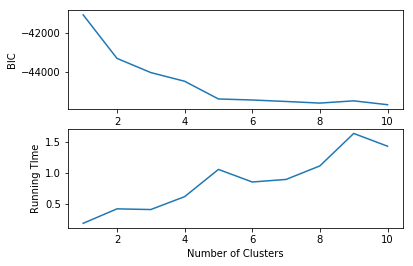

In [19]:
#Wine Data - PCA Dimensionality Reduced GMM
gMM(pcDF, range(1, 11))

For n_clusters=2, The Silhouette Coefficient is 0.46571443365652637
For n_clusters=3, The Silhouette Coefficient is 0.41804463130860686
For n_clusters=4, The Silhouette Coefficient is 0.38525761059028557
For n_clusters=5, The Silhouette Coefficient is 0.4015121268488733
For n_clusters=6, The Silhouette Coefficient is 0.3829685457497266
For n_clusters=7, The Silhouette Coefficient is 0.377082833570374
For n_clusters=8, The Silhouette Coefficient is 0.39692058517187045
For n_clusters=9, The Silhouette Coefficient is 0.37344394108144807
For n_clusters=10, The Silhouette Coefficient is 0.37079170258515814


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

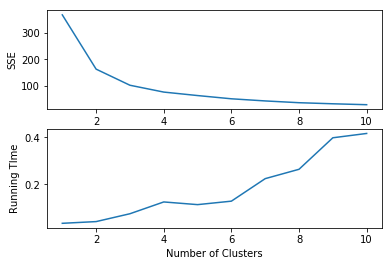

In [20]:
#Abalone - PCA Dimensionality Reduced KMeans
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("abalone.csv", "sex")

pc = PCA(n_components = 2, random_state= seed).fit_transform(x)
pcDF = pd.DataFrame(data = pc, columns = ['principal component 1', 'principal component 2'])

kMeans(pcDF, range(1, 11))

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

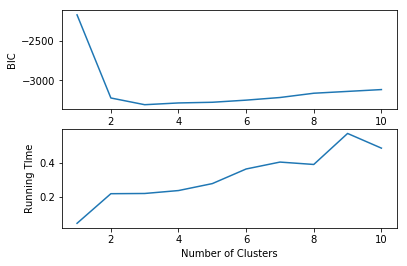

In [21]:
#Abalone - PCA Dimensionality Reduced GMM
gMM(pcDF, range(1, 11))

For n_clusters=2, The Silhouette Coefficient is 0.0947935430048701
For n_clusters=3, The Silhouette Coefficient is 0.10901137585670895
For n_clusters=4, The Silhouette Coefficient is 0.11481102039020447
For n_clusters=5, The Silhouette Coefficient is 0.11629419564416647
For n_clusters=6, The Silhouette Coefficient is 0.12274621515961072
For n_clusters=7, The Silhouette Coefficient is 0.1296420465301509
For n_clusters=8, The Silhouette Coefficient is 0.1317607345923622
For n_clusters=9, The Silhouette Coefficient is 0.13048215753694165
For n_clusters=10, The Silhouette Coefficient is 0.12706630273458674


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

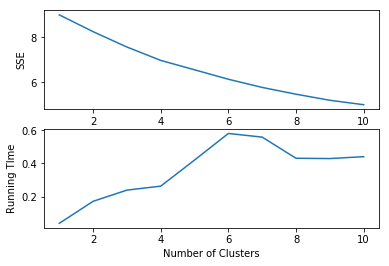

In [22]:
#Wine Data - ICA Dimensionality Reduced KMeans
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("winequality-white.csv", "GoodQuality")

ic = FastICA(n_components = 9, random_state= seed).fit_transform(x)
icDF = pd.DataFrame(data = ic, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 'principal component 9'])

kMeans(icDF, range(1, 11))

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

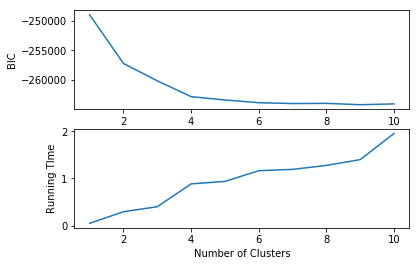

In [23]:
#Wine Data - ICA Dimensionality Reduced GMM
gMM(icDF, range(1, 11))

For n_clusters=2, The Silhouette Coefficient is 0.17610226668095638
For n_clusters=3, The Silhouette Coefficient is 0.16928214338968517
For n_clusters=4, The Silhouette Coefficient is 0.18065732555410377
For n_clusters=5, The Silhouette Coefficient is 0.18125271040025737
For n_clusters=6, The Silhouette Coefficient is 0.18228380071438152
For n_clusters=7, The Silhouette Coefficient is 0.1904424579455828
For n_clusters=8, The Silhouette Coefficient is 0.1673667751859898
For n_clusters=9, The Silhouette Coefficient is 0.1579556840850653
For n_clusters=10, The Silhouette Coefficient is 0.14970694463792464


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

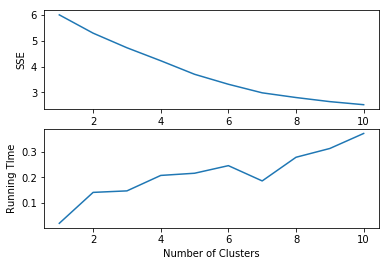

In [24]:
#Abalone - ICA Dimensionality Reduced KMeans
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("abalone.csv", "sex")

ic = FastICA(n_components = 6, random_state= seed).fit_transform(x)
icDF = pd.DataFrame(data = ic, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])

kMeans(icDF, range(1, 11))

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

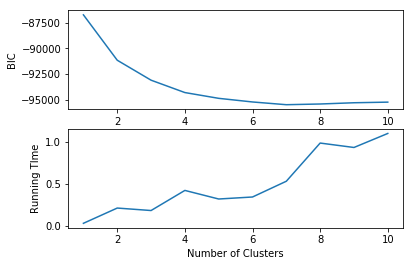

In [25]:
#Abalone - ICA Dimensionality Reduced GMM
gMM(icDF, range(1, 11))

For n_clusters=2, The Silhouette Coefficient is 0.2869577531641586
For n_clusters=3, The Silhouette Coefficient is 0.29857366639467753
For n_clusters=4, The Silhouette Coefficient is 0.26149249828408105
For n_clusters=5, The Silhouette Coefficient is 0.240956451553387
For n_clusters=6, The Silhouette Coefficient is 0.2310666480747694
For n_clusters=7, The Silhouette Coefficient is 0.22259932647893035
For n_clusters=8, The Silhouette Coefficient is 0.22699456908120294
For n_clusters=9, The Silhouette Coefficient is 0.22145139733265826
For n_clusters=10, The Silhouette Coefficient is 0.20241825991178328


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

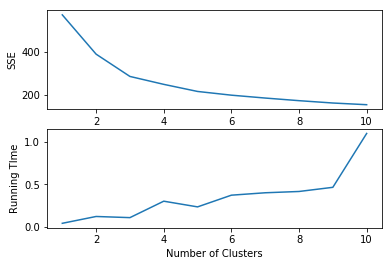

In [26]:
#Wine Data - RP Dimensionality Reduced KMeans
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("winequality-white.csv", "GoodQuality")
    
rp = SparseRandomProjection(n_components = 6, random_state= seed).fit_transform(x)
rpDF = pd.DataFrame(data = rp, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])

kMeans(rpDF, range(1, 11))

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

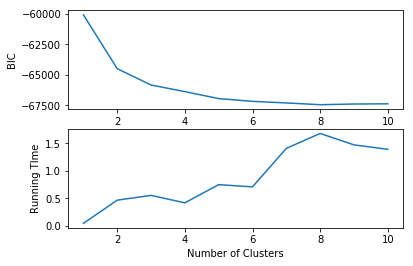

In [27]:
#Wine Data - RP Dimensionality Reduced GMM
gMM(rpDF, range(1, 11))

For n_clusters=2, The Silhouette Coefficient is 0.43688361258188035
For n_clusters=3, The Silhouette Coefficient is 0.39478159993880485
For n_clusters=4, The Silhouette Coefficient is 0.35083778913685565
For n_clusters=5, The Silhouette Coefficient is 0.3203588340278968
For n_clusters=6, The Silhouette Coefficient is 0.29577786553965707
For n_clusters=7, The Silhouette Coefficient is 0.29434499403786424
For n_clusters=8, The Silhouette Coefficient is 0.26981205996340785
For n_clusters=9, The Silhouette Coefficient is 0.24935395833504823
For n_clusters=10, The Silhouette Coefficient is 0.25638199484324825


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

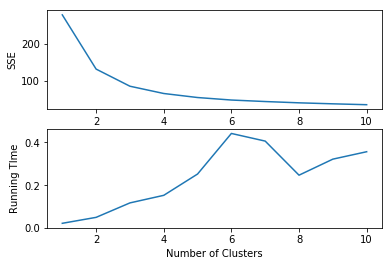

In [28]:
#Abalone - RP Dimensionality Reduced KMeans
scaler = preprocessing.MinMaxScaler()
x, y = loadCSVData("abalone.csv", "sex")
    
rp = SparseRandomProjection(n_components = 6, random_state= seed).fit_transform(x)
rpDF = pd.DataFrame(data = rp, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6'])

kMeans(rpDF, range(1, 11))

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

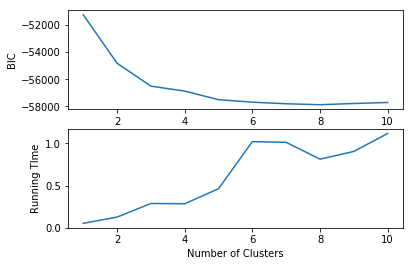

In [29]:
#Abalone - RP Dimensionality Reduced GMM
gMM(rpDF, range(1, 11))

In [31]:
wineDF = pd.read_csv("winequality-white.csv")

###Get Feature and Target variables
features = wineDF.columns.values[:-1]
target = wineDF.columns.values[-1]

###One Hot Encode Categorical Predictors
X = wineDF[features]

Y = wineDF[[target]]

pc = PCA(n_components = 10, random_state = seed).fit_transform(X)
X = pd.DataFrame(data = pc, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 'principal component 9', 'principal component 10'])

nnY = pd.get_dummies(Y)
nnY.drop('GoodQuality_No', 1, inplace = True)
nnY.columns = ['GoodQuality']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, nnY, test_size = 0.2, random_state = seed)

Xtrain = Xtrain.reset_index()
Xtest = Xtest.reset_index()
Ytrain = Ytrain.reset_index()
Ytest = Ytest.reset_index()

Xtrain.drop('index', 1, inplace = True)
Xtest.drop('index', 1, inplace = True)
Ytrain.drop('index', 1, inplace = True)
Ytest.drop('index', 1, inplace = True)

Ytrain = Ytrain.values.ravel()
Ytest = Ytest.values.ravel()

scaler = preprocessing.MinMaxScaler()
scaler.fit(X = Xtrain)

Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

def plotLearningCurves(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")

    plt.legend(loc="best")
    return plt


def nnMLPModel(Xtrain, Ytrain, Xtest, Ytest, cv, seed, neurons = [15], layers = 3, activation = ["relu"], solver = ["adam"], alpha = [0.0001], learning_rate = ["constant"], learning_rate_init = [0.001], max_iter = [500]):
    #nnModel = MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter= 500)
    #nnModel.fit(Xtrain, Ytrain)
    hidden_layer_sizes = []
    
    for i in range(1, layers + 1):
        hidden_layer_sizes += [x for x in itertools.product(neurons, repeat= i)]
    
    #Hyper-parameter Tuning
    parameters = {'hidden_layer_sizes': hidden_layer_sizes, 'activation': activation, 'solver': solver, 'alpha': alpha, 'learning_rate': learning_rate, 'learning_rate_init':learning_rate_init, 'max_iter': max_iter}
    nnModel = GridSearchCV(MLPClassifier(random_state = seed), parameters, cv = cv, n_jobs = 4)
    nnModel.fit(Xtrain, Ytrain)
    
    cvAccuracy = nnModel.best_score_
    cvBestParams = nnModel.best_params_

    YPrediction = nnModel.predict(Xtest)   

    #Calcuate Accuracy Metrics
    testAccuracy = accuracy_score(Ytest,YPrediction)
    cm = confusion_matrix(Ytest, YPrediction)
    testSensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    testSpecificity = cm[1,1]/(cm[1,0]+cm[1,1])
    
    return [Xtrain.shape[0], Xtest.shape[0], cvAccuracy, cvBestParams, testAccuracy, testSensitivity, testSpecificity, cm]

In [32]:
learningRate = ["constant"]
neurons = range(20, 40, 10)
layers = 3
activation = ["logistic", "relu"]
solver = ['adam']
#alpha = [i/100000 for i in range(0, 1050, 50)]
alpha = [0.0001]
#max_iter = [i for i in range(100, 1100, 100)]
max_iter = [1000]

nnTrainSize, nnTestSize, nnCVAccuracy, nnBestParameters, nnTestAccuracy, nnTestSensitivity, nnTestSpecificity, nnCM = nnMLPModel(Xtrain, Ytrain, Xtest, Ytest, cv = 4, seed = seed, learning_rate = learningRate, neurons = neurons
          , layers = layers, activation = activation, solver = solver, alpha = alpha, max_iter = max_iter)


In [33]:
#Without PCA
#nnTestAccuracy = 0.77347
#nnTestSensitivity = 0.59587
#nnTestSpecificity = 0.86739

#With PCA
#nnTestAccuracy = 0.75612
#nnTestSensitivity = 0.61773
#nnTestSpecificity = 0.82542

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

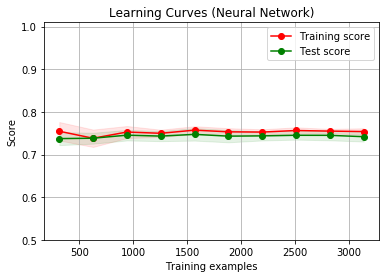

In [34]:
nnModel = MLPClassifier(random_state = seed, activation= nnBestParameters['activation'], alpha = nnBestParameters['alpha']
                       , hidden_layer_sizes = nnBestParameters['hidden_layer_sizes'], learning_rate=nnBestParameters['learning_rate']
                       , learning_rate_init=nnBestParameters['learning_rate_init'], max_iter = nnBestParameters['max_iter'])
nnModel.fit(Xtrain, Ytrain)

plotLearningCurves(nnModel, "Learning Curves (Neural Network)", Xtrain, Ytrain, ylim=(0.5, 1.01), cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
                        n_jobs=4, train_sizes=np.linspace(.1, 1.0, 10))

In [35]:
#Wine Data - PCA Dimensionality Reduced KMeans
scaler = preprocessing.MinMaxScaler()
wineKMeansX, Y = loadCSVData("winequality-white.csv", "GoodQuality")

pc = PCA(n_components = 10, random_state= seed).fit_transform(wineKMeansX)
wineKMeansX = pd.DataFrame(data = pc, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 'principal component 9', 'principal component 10'])

wineKMeans = KMeans(n_clusters = 2, max_iter = 1000, random_state= seed).fit(wineKMeansX)
wineKMeansX["cluster"] = wineKMeans.labels_

nnY = pd.get_dummies(Y)
nnY.drop('No', 1, inplace = True)
nnY.columns = ['GoodQuality']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(wineKMeansX, nnY, test_size = 0.2, random_state = seed)

Xtrain = Xtrain.reset_index()
Xtest = Xtest.reset_index()
Ytrain = Ytrain.reset_index()
Ytest = Ytest.reset_index()

Xtrain.drop('index', 1, inplace = True)
Xtest.drop('index', 1, inplace = True)
Ytrain.drop('index', 1, inplace = True)
Ytest.drop('index', 1, inplace = True)

Ytrain = Ytrain.values.ravel()
Ytest = Ytest.values.ravel()

nnTrainSize, nnTestSize, nnCVAccuracy, nnBestParameters, nnTestAccuracy, nnTestSensitivity, nnTestSpecificity, nnCM = nnMLPModel(Xtrain, Ytrain, Xtest, Ytest, cv = 4, seed = seed, learning_rate = learningRate, neurons = neurons
          , layers = layers, activation = activation, solver = solver, alpha = alpha, max_iter = max_iter)

In [36]:
#With PCA
#nnTestAccuracy = 0.77258
#nnTestSensitivity = 0.62691
#nnTestSpecificity = 0.83614

In [37]:
#Abalone - PCA Dimensionality Reduced KMeans
scaler = preprocessing.MinMaxScaler()
abaloneKMeansX, Y = loadCSVData("abalone.csv", "sex")

pc = PCA(n_components = 8, random_state= seed).fit_transform(abaloneKMeansX)
abaloneKMeansX = pd.DataFrame(data = pc, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8'])

abaloneKMeans = KMeans(n_clusters = 2, max_iter = 1000, random_state= seed).fit(abaloneKMeansX)
abaloneKMeansX["cluster"] = abaloneKMeans.labels_

nnY = pd.get_dummies(Y)
nnY.drop('M', 1, inplace = True)
nnY.columns = ['sex']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(abaloneKMeansX, nnY, test_size = 0.2, random_state = seed)

Xtrain = Xtrain.reset_index()
Xtest = Xtest.reset_index()
Ytrain = Ytrain.reset_index()
Ytest = Ytest.reset_index()

Xtrain.drop('index', 1, inplace = True)
Xtest.drop('index', 1, inplace = True)
Ytrain.drop('index', 1, inplace = True)
Ytest.drop('index', 1, inplace = True)

Ytrain = Ytrain.values.ravel()
Ytest = Ytest.values.ravel()

nnTrainSize, nnTestSize, nnCVAccuracy, nnBestParameters, nnTestAccuracy, nnTestSensitivity, nnTestSpecificity, nnCM = nnMLPModel(Xtrain, Ytrain, Xtest, Ytest, cv = 4, seed = seed, learning_rate = learningRate, neurons = neurons
          , layers = layers, activation = activation, solver = solver, alpha = alpha, max_iter = max_iter)

In [38]:
#With PCA
#nnTestAccuracy = 0.54144
#nnTestSensitivity = 0.70569
#nnTestSpecificity = 0.33466
nnTestAccuracy

0.5414462081128748